# Implementing a Recommender System using LightGCN

In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from modeling.sampling import sample_minibatch
from modeling.metrics import calculate_metrics
from modeling.losses import BPR_loss
from modeling.models.lightGCN import LightGCN
import torch.nn.functional as F

import time

import torch
from torch import optim

In [2]:
# Lets start by loading the data
data = torch.load("data/hetero_data_no_coauthor.pt", weights_only=False)

# We only need the edges for light GCN
edge_index = data["author", "writes", "paper"].edge_index
author_ids = data["author"].node_id
paper_ids = data["paper"].node_id

print(f"Number of authors: {len(author_ids)}")
print(f"Number of papers: {len(paper_ids)}")
print(f"Number of edges: {edge_index.shape[1]}")

Number of authors: 90941
Number of papers: 63854
Number of edges: 320187


In [3]:
# split the edges of the graph using a 80/10/10 train/validation/test split
num_authors, num_papers = len(author_ids), len(paper_ids)
num_interactions = edge_index.shape[1]
all_indices = [i for i in range(num_interactions)]

# Here we enumearte the edges
# Then we split them into train, val, test sets
train_indices, test_indices = train_test_split(
    all_indices,
    test_size=0.2,
    random_state=1,
)
train_message_passing_indiceies, train_supervision_indices = train_test_split(
    train_indices,
    test_size=0.3,
    random_state=1,
)
val_indices, test_indices = train_test_split(
    test_indices,
    test_size=0.5,
    random_state=1,
)

train_message_passing_edge_index = edge_index[:, train_message_passing_indiceies]
train_supervision_edge_index = edge_index[:, train_supervision_indices]
train_edge_index = edge_index[:, train_indices]
val_edge_index = edge_index[:, val_indices]
test_edge_index = edge_index[:, test_indices]

In [4]:
# define contants
ITERATIONS = 10000
BATCH_SIZE = 1024
LR = 1e-3
ITERS_PER_EVAL = 1000
K = 20

In [5]:
# setup
model = LightGCN(
    num_authors=num_authors,
    num_papers=num_papers,
    embedding_dim=64,
    K=6,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}.")


model = model.to(device)
model.train()

optimizer = optim.Adam(model.parameters(), lr=LR)

edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
train_message_passing_edge_index = train_message_passing_edge_index.to(device)
train_supervision_edge_index = train_supervision_edge_index.to(device)
val_edge_index = val_edge_index.to(device)

Using device cuda.


In [6]:
# training loop
train_losses = []
batching_times = []
forward_times = []
loss_times = []
backward_times = []

for iter in range(ITERATIONS):

    # mini batching
    start_time = time.time()
    pos_edge_index, neg_edge_index = sample_minibatch(
        train_supervision_edge_index,
        BATCH_SIZE,
        neg_sample_ratio=1,
    )
    pos_edge_index = pos_edge_index.to(device)
    neg_edge_index = neg_edge_index.to(device)
    batch_edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=1)
    batching_times.append(time.time() - start_time)

    # forward propagation
    start_time = time.time()
    scores = model.forward(
        message_passing_edge_index=train_message_passing_edge_index,
        supervision_edge_index=batch_edge_index,
    )
    pos_scores = scores[: pos_edge_index.shape[1]]
    neg_scores = scores[pos_edge_index.shape[1] :]
    forward_times.append(time.time() - start_time)

    # loss computation
    start_time = time.time()
    train_loss = BPR_loss(
        pos_scores,
        neg_scores,
    )
    loss_times.append(time.time() - start_time)

    # backward propagation
    start = time.time()
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    backward_times.append(time.time() - start)

    if (iter + 1) % ITERS_PER_EVAL == 0:
        model.eval()

        with torch.no_grad():
            # typically we would use the supervising edges as well here
            # But LightGCN does not have parameters, it only learns from the edges we use during training is is fix after that
            user_embedding, item_embedding = model.get_embeddings(train_message_passing_edge_index)

        val_recall, val_precision = calculate_metrics(
            user_embedding,
            item_embedding,
            val_edge_index,
            [train_edge_index],
            K,
            batch_size=1024,
        )

        train_recall, train_precision = calculate_metrics(
            user_embedding,
            item_embedding,
            train_supervision_edge_index,
            [train_message_passing_edge_index],
            K,
            batch_size=1024,
        )

        print(
            f"[Iteration {iter + 1}/{ITERATIONS}] train_loss: {train_loss.item():.05f}, val_recall@{K}: {val_recall:.05f}, val_precision@{K}: {val_precision:.05f}, train_recall@{K}: {train_recall:.05f}, train_precision@{K}: {train_precision:.05f}"
        )
        train_losses.append(train_loss.item())
        model.train()

[Iteration 1000/10000] train_loss: 0.66573, val_recall@20: 0.02072, val_precision@20: 0.00171, train_recall@20: 0.79182, train_precision@20: 0.07382
[Iteration 2000/10000] train_loss: 0.56449, val_recall@20: 0.02787, val_precision@20: 0.00233, train_recall@20: 0.74511, train_precision@20: 0.07012


KeyboardInterrupt: 

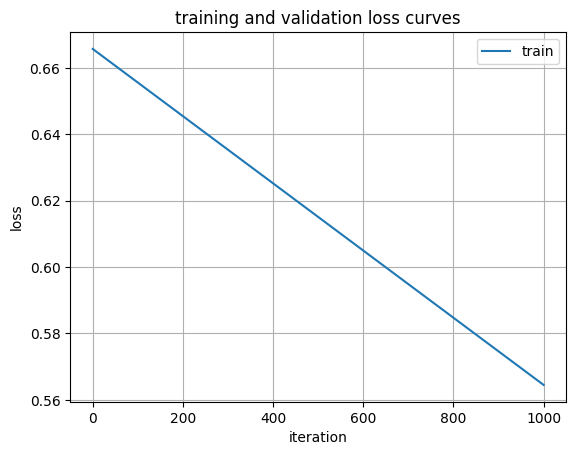

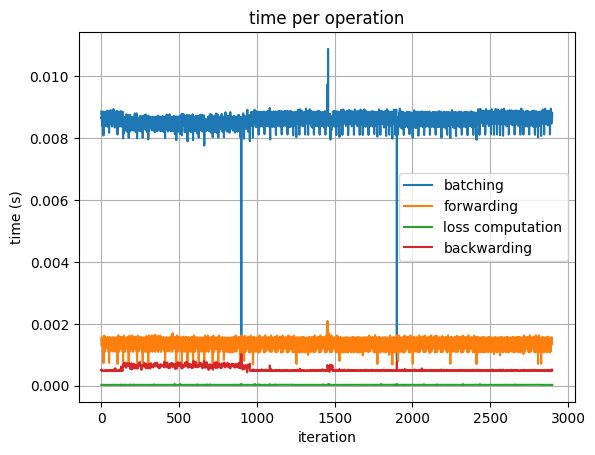

In [7]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
plt.plot(iters, train_losses, label="train")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.title("training and validation loss curves")
plt.legend()
plt.grid()
plt.show()

plt.plot(batching_times[100:], label="batching")
plt.plot(forward_times[100:], label="forwarding")
plt.plot(loss_times[100:], label="loss computation")
plt.plot(backward_times[100:], label="backwarding")
plt.xlabel("iteration")
plt.ylabel("time (s)")
plt.title("time per operation")
plt.legend()
plt.grid()
plt.show()

In [ ]:
model.eval()
test_edge_index = test_edge_index.to(device)

with torch.no_grad():
    with torch.no_grad():
        user_embedding, item_embedding = model.get_embeddings(train_message_passing_edge_index)

    test_recall, test_precision = calculate_metrics(
        user_embedding,
        item_embedding,
        test_edge_index,
        [train_edge_index, val_edge_index],
        K,
        batch_size=1024,
    )

print(
    f"[test_recall@{K}: {round(test_recall, 5)}, test_precision@{K}: {round(test_precision, 5)}"
)